# Appliances Energy Prediction - Exploratory Data Analysis

## IMPORTS & CONFIGURATION

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller, kpss, acf, pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy.stats import skew
import warnings
warnings.filterwarnings('ignore')

In [2]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

##  DATA LOADING & INITIAL EXPLORATION

In [3]:
# Load dataset
df = pd.read_csv("C:/Users/lekshmi/Desktop/ml projects/appliances energy prediction/KAG_energydata_complete.csv")

print(f"\n📊 Dataset Shape: {df.shape}")
print(f"   - Rows: {df.shape[0]:,}")
print(f"   - Columns: {df.shape[1]}")

print("\n📋 First Few Rows:")
print(df.head())

print("\n📝 Column Names:")
print(df.columns.tolist())


📊 Dataset Shape: (19735, 29)
   - Rows: 19,735
   - Columns: 29

📋 First Few Rows:
                  date  Appliances  lights     T1       RH_1    T2       RH_2  \
0  2016-01-11 17:00:00          60      30  19.89  47.596667  19.2  44.790000   
1  2016-01-11 17:10:00          60      30  19.89  46.693333  19.2  44.722500   
2  2016-01-11 17:20:00          50      30  19.89  46.300000  19.2  44.626667   
3  2016-01-11 17:30:00          50      40  19.89  46.066667  19.2  44.590000   
4  2016-01-11 17:40:00          60      40  19.89  46.333333  19.2  44.530000   

      T3       RH_3         T4       RH_4         T5   RH_5        T6  \
0  19.79  44.730000  19.000000  45.566667  17.166667  55.20  7.026667   
1  19.79  44.790000  19.000000  45.992500  17.166667  55.20  6.833333   
2  19.79  44.933333  18.926667  45.890000  17.166667  55.09  6.560000   
3  19.79  45.000000  18.890000  45.723333  17.166667  55.09  6.433333   
4  19.79  45.000000  18.890000  45.530000  17.200000  55.09  6.3

## Dataset Variables
- **Appliances**: Energy consumption (target)
- **date**: Timestamp
- **lights**: Lighting energy usage
- **T1–T9**: Indoor temperatures
- **RH_1–RH_9**: Indoor humidity
- **T_out, RH_out**: Outdoor temperature and humidity
- **Press_mm_hg**: Air pressure
- **Windspeed**: Wind speed
- **Visibility**: Visibility
- **Tdewpoint**: Dew point temperature
- **rv1, rv2**: Random (noise) variables


## DATA TYPES & MISSING VALUES

In [4]:
print("\n🔍 Data Types:")
print(df.dtypes)

missing = df.isnull().sum()
missing_pct = (missing / len(df)) * 100
missing_df = pd.DataFrame({'Missing_Count': missing, 'Percentage': missing_pct})
missing_df = missing_df[missing_df['Missing_Count'] > 0]

if len(missing_df) > 0:
    print("\n⚠️ Missing Values Found:")
    print(missing_df)
else:
    print("\n✅ No missing values found!")

print(f"\n📊 Duplicate Rows: {df.duplicated().sum()}")



🔍 Data Types:
date            object
Appliances       int64
lights           int64
T1             float64
RH_1           float64
T2             float64
RH_2           float64
T3             float64
RH_3           float64
T4             float64
RH_4           float64
T5             float64
RH_5           float64
T6             float64
RH_6           float64
T7             float64
RH_7           float64
T8             float64
RH_8           float64
T9             float64
RH_9           float64
T_out          float64
Press_mm_hg    float64
RH_out         float64
Windspeed      float64
Visibility     float64
Tdewpoint      float64
rv1            float64
rv2            float64
dtype: object

✅ No missing values found!

📊 Duplicate Rows: 0


Dataset has 19,735 records and 29 features with no missing values. Data types: Appliances and lights (int64), environmental variables (float64), date (object/string). Most features are continuous numerical variables.


date is stored as an object, not as a datetime type.

Appliances and lights are integer-valued variables.

All remaining 26 features are continuous (float64), representing environmental measurements.

No categorical features are present in the dataset.

## TIME INDEX CONVERSION

In [5]:
df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace=True)
df.sort_index(inplace=True)

start_date = df.index.min()
end_date = df.index.max()
duration = end_date - start_date

print(f"\n📅 Time Range:")
print(f"   Start: {start_date}")
print(f"   End: {end_date}")
print(f"   Duration: {duration.days} days ({df.index.nunique()} unique dates)")

# Check time spacing
time_diffs = df.index.to_series().diff().value_counts().head()
print(f"\n⏱️ Time Spacing:")
print(time_diffs)

print(f"\n✅ All records are evenly spaced at 10-minute intervals")


📅 Time Range:
   Start: 2016-01-11 17:00:00
   End: 2016-05-27 18:00:00
   Duration: 137 days (19735 unique dates)

⏱️ Time Spacing:
date
0 days 00:10:00    19734
Name: count, dtype: int64

✅ All records are evenly spaced at 10-minute intervals


The time difference between consecutive records is:Exactly 10 minutes for all 19,734 intervals
No missing, duplicated, or irregular timestamps.

In [21]:
start_date = df.index.min()
end_date = df.index.max()

print("Start Date:", start_date)
print("End Date:", end_date)


date_range = end_date - start_date
print("Total Duration:", date_range)

Start Date: 2016-01-11 17:00:00
End Date: 2016-05-27 18:00:00
Total Duration: 137 days 01:00:00


## FEATURE OVERVIEW

In [6]:
print("\n📌 Target Variable: Appliances (Energy Consumption in Wh)")
print("\n📌 Feature Categories:")

target = 'Appliances'
indoor_temp = [col for col in df.columns if col.startswith('T') and col not in ['T_out']]
indoor_hum = [col for col in df.columns if col.startswith('RH_') and col != 'RH_out']
weather = ['T_out', 'RH_out', 'Press_mm_hg', 'Windspeed', 'Visibility', 'Tdewpoint']
other = ['lights']
noise = ['rv1', 'rv2']

print(f"   - Lights: {other}")
print(f"   - Indoor Temperature (T1-T9): {len(indoor_temp)} features")
print(f"   - Indoor Humidity (RH_1-RH_9): {len(indoor_hum)} features")
print(f"   - Outdoor/Weather: {weather}")
print(f"   - Noise Variables: {noise}")


📌 Target Variable: Appliances (Energy Consumption in Wh)

📌 Feature Categories:
   - Lights: ['lights']
   - Indoor Temperature (T1-T9): 10 features
   - Indoor Humidity (RH_1-RH_9): 9 features
   - Outdoor/Weather: ['T_out', 'RH_out', 'Press_mm_hg', 'Windspeed', 'Visibility', 'Tdewpoint']
   - Noise Variables: ['rv1', 'rv2']


## STATISTICAL SUMMARY

In [7]:
print("\n📊 Target Variable (Appliances) Statistics:")
print(f"   Count:       {df[target].count():,}")
print(f"   Mean:        {df[target].mean():.2f} Wh")
print(f"   Median:      {df[target].median():.2f} Wh")
print(f"   Std Dev:     {df[target].std():.2f} Wh")
print(f"   Min:         {df[target].min():.2f} Wh")
print(f"   Max:         {df[target].max():.2f} Wh")
print(f"   Range:       {df[target].max() - df[target].min():.2f} Wh")

print("\n📈 Distribution Metrics:")
print(f"   Skewness:    {df[target].skew():.4f} (Right-skewed)")
print(f"   Kurtosis:    {df[target].kurtosis():.4f}")
print(f"   CV:          {(df[target].std() / df[target].mean()):.4f}")

# Outlier detection
Q1 = df[target].quantile(0.25)
Q3 = df[target].quantile(0.75)
IQR = Q3 - Q1
outliers = df[(df[target] < Q1 - 1.5*IQR) | (df[target] > Q3 + 1.5*IQR)]

print(f"\n🎯 Outlier Analysis (IQR Method):")
print(f"   Q1: {Q1:.2f} Wh")
print(f"   Q3: {Q3:.2f} Wh")
print(f"   IQR: {IQR:.2f} Wh")
print(f"   Outliers: {len(outliers)} ({len(outliers)/len(df)*100:.2f}%)")

# Full statistical summary
print("\n📋 Complete Statistical Summary:")
print(df.describe().T)



📊 Target Variable (Appliances) Statistics:
   Count:       19,735
   Mean:        97.69 Wh
   Median:      60.00 Wh
   Std Dev:     102.52 Wh
   Min:         10.00 Wh
   Max:         1080.00 Wh
   Range:       1070.00 Wh

📈 Distribution Metrics:
   Skewness:    3.3864 (Right-skewed)
   Kurtosis:    13.6679
   CV:          1.0494

🎯 Outlier Analysis (IQR Method):
   Q1: 50.00 Wh
   Q3: 100.00 Wh
   IQR: 50.00 Wh
   Outliers: 2138 (10.83%)

📋 Complete Statistical Summary:
               count        mean         std         min         25%  \
Appliances   19735.0   97.694958  102.524891   10.000000   50.000000   
lights       19735.0    3.801875    7.935988    0.000000    0.000000   
T1           19735.0   21.686571    1.606066   16.790000   20.760000   
RH_1         19735.0   40.259739    3.979299   27.023333   37.333333   
T2           19735.0   20.341219    2.192974   16.100000   18.790000   
RH_2         19735.0   40.420420    4.069813   20.463333   37.900000   
T3           19735.0

Key observations from statistical summary: Appliances show mean (97.69) much higher than median (60.00) with wide range (10–1080 Wh), indicating right-skewness and outliers. Lights are zero-inflated with median and 75th percentile at 0 and occasional peaks up to 70. Indoor temperatures (T1–T9) are stable (~19–22°C) with low variance, suggesting weak standalone predictive power. Indoor humidity (RH_1–RH_9) has higher variability, with some sensors near 100%, making it potentially more influential. Outdoor variables show seasonal and weather-driven variation (T_out −5 to 26°C, RH_out up to 100%). Pressure shows minimal variance and likely low predictive value. Random variables (rv1, rv2) have identical statistics and should be excluded.


##  TARGET VARIABLE VISUALIZATION

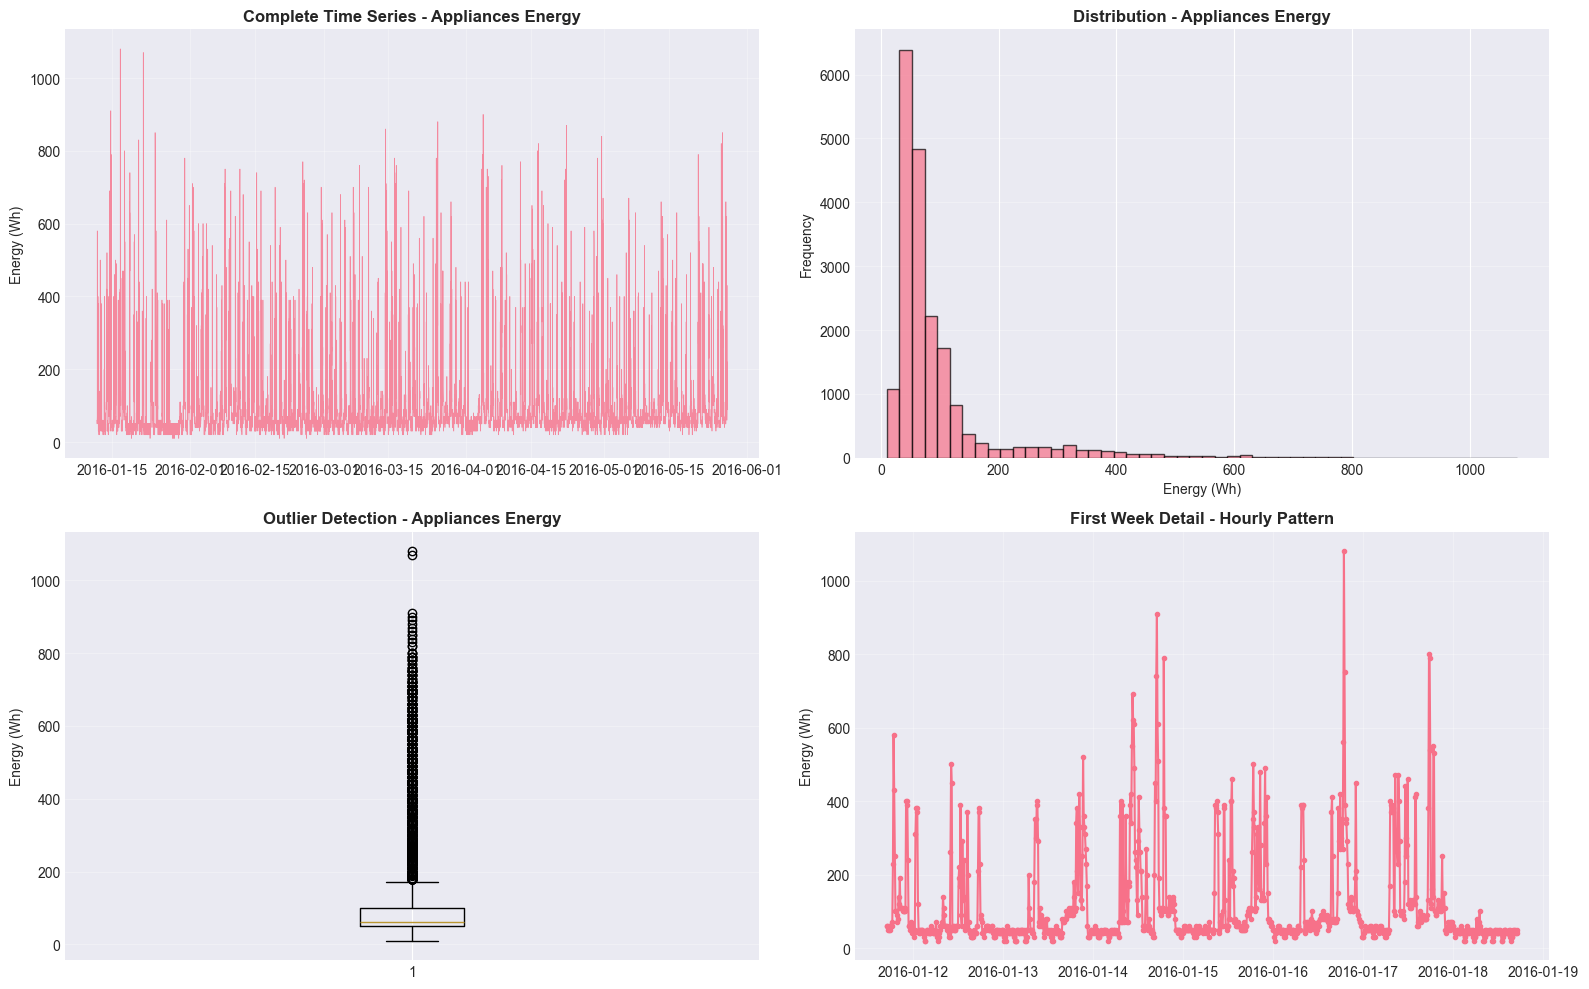


✅ Target variable visualization complete


In [8]:
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# Time series plot
axes[0, 0].plot(df.index, df[target], linewidth=0.5, alpha=0.8)
axes[0, 0].set_title("Complete Time Series - Appliances Energy", fontsize=12, fontweight='bold')
axes[0, 0].set_ylabel("Energy (Wh)")
axes[0, 0].grid(True, alpha=0.3)

# Distribution
axes[0, 1].hist(df[target], bins=50, edgecolor='black', alpha=0.7)
axes[0, 1].set_title("Distribution - Appliances Energy", fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel("Energy (Wh)")
axes[0, 1].set_ylabel("Frequency")
axes[0, 1].grid(axis='y', alpha=0.3)

# Box plot
axes[1, 0].boxplot(df[target], vert=True)
axes[1, 0].set_title("Outlier Detection - Appliances Energy", fontsize=12, fontweight='bold')
axes[1, 0].set_ylabel("Energy (Wh)")
axes[1, 0].grid(axis='y', alpha=0.3)

# First week detail
first_week = df.loc[:df.index.min() + pd.Timedelta(days=7)]
axes[1, 1].plot(first_week.index, first_week[target], marker='o', markersize=3)
axes[1, 1].set_title("First Week Detail - Hourly Pattern", fontsize=12, fontweight='bold')
axes[1, 1].set_ylabel("Energy (Wh)")
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n✅ Target variable visualization complete")

Key observations: Appliances energy consumption shows a highly intermittent and event-driven pattern with long periods of low baseline usage and frequent sharp spikes reaching 1000+ Wh. There is no clear long-term upward or downward trend, but strong short-term volatility with repeated spikes, suggesting usage driven by human activity cycles. Most values remain clustered at a stable low-consumption baseline, indicating standby or background usage, while large variance over short intervals confirms high skewness and non-stationarity.

Distribution analysis shows a strongly right-skewed, non-normal pattern with most values concentrated between 10–100 Wh and a long tail extending beyond 1000 Wh. Extreme but meaningful outliers correspond to the spikes observed in the time series. A large mass near zero reflects minimal or standby appliance usage. Overall, the target variable is dominated by low values with occasional extreme peaks, violating normality assumptions and indicating energy consumption is driven more by time-of-day, occupancy, and appliance activation events than by gradual environmental changes.


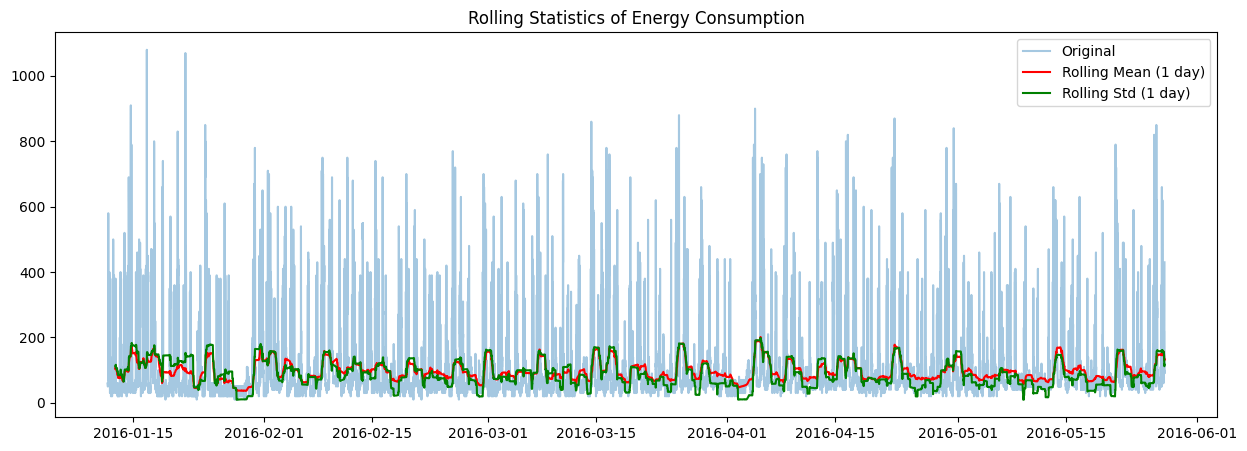

In [16]:
rolling_mean = df[target].rolling(window=144).mean()  # 1-day window
rolling_std = df[target].rolling(window=144).std()

plt.figure(figsize=(15,5))
plt.plot(df[target], alpha=0.4, label='Original')
plt.plot(rolling_mean, color='red', label='Rolling Mean (1 day)')
plt.plot(rolling_std, color='green', label='Rolling Std (1 day)')
plt.legend()
plt.title("Rolling Statistics of Energy Consumption")
plt.show()


Rolling statistics (1-day window) show that the rolling mean is not constant, with clear rises and falls over time, indicating non-stationarity in the mean. The rolling standard deviation also varies, with clusters of high and low volatility aligned with usage intensity, confirming heteroscedastic behavior. Repeating fluctuations in the rolling mean suggest cyclic patterns likely driven by daily routines, weekly occupancy, and seasonal effects. Although the raw series is highly noisy and spiky, rolling statistics reveal underlying structure. Overall, appliance energy consumption is non-stationary in both mean and variance, influenced by time-dependent human activity patterns, and violates stationarity assumptions required by classical time-series models.


## TEMPORAL PATTERNS - HOURLY


⏰ Hourly Statistics:
      count        mean  median         std  min   max
hour                                                  
0       822   52.785888    50.0   25.615928   20   380
1       822   51.326034    50.0   19.288647   20   380
2       822   49.075426    50.0   10.694366   20    80
3       822   48.236010    50.0   11.445056   20    80
4       822   49.355231    50.0   10.244173   10    80
5       822   52.737226    50.0   27.301297   20   380
6       822   57.712895    50.0   46.446179   10   650
7       822   78.649635    60.0   81.476935   20   700
8       822  106.143552    60.0  112.102458   10   850
9       822  112.785888    70.0  117.313204   10   820
10      822  125.377129    70.0  136.933677   20   860
11      822  133.126521    70.0  140.643487   10   780
12      822  123.637470    80.0  118.195033   20   790
13      822  124.744526    80.0  119.669136   10   750
14      822  108.284672    70.0  103.203743   20   710
15      822  105.827251    80.0  105.711368

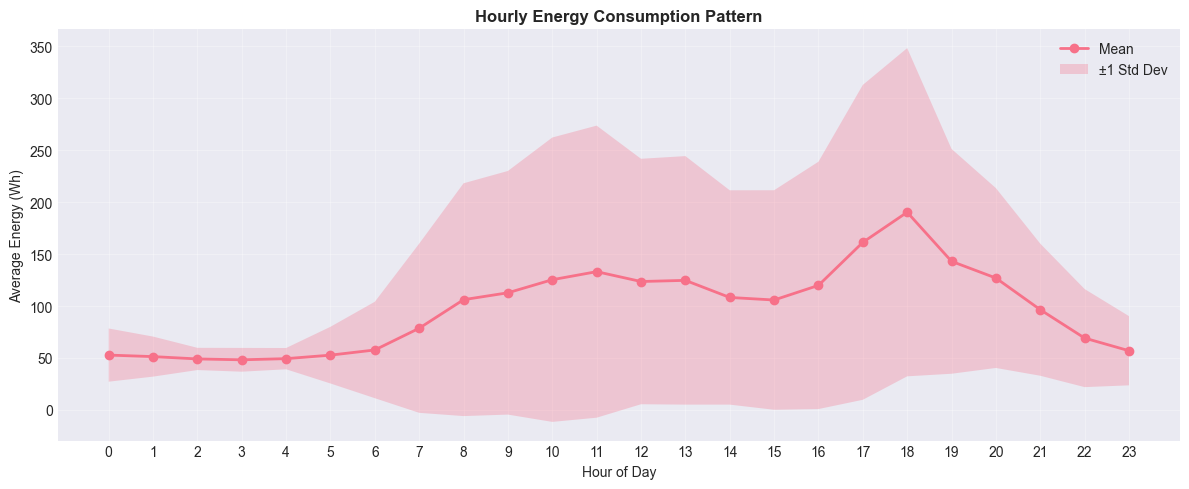


🔍 Key Insights:
   - Lowest usage: 3:00 (48.24 Wh)
   - Highest usage: 18:00 (190.36 Wh)


In [9]:
df['hour'] = df.index.hour
hourly_stats = df.groupby('hour')[target].agg(['count', 'mean', 'median', 'std', 'min', 'max'])

print("\n⏰ Hourly Statistics:")
print(hourly_stats)

fig, ax = plt.subplots(figsize=(12, 5))
ax.plot(hourly_stats.index, hourly_stats['mean'], marker='o', linewidth=2, markersize=6, label='Mean')
ax.fill_between(hourly_stats.index,
                hourly_stats['mean'] - hourly_stats['std'],
                hourly_stats['mean'] + hourly_stats['std'],
                alpha=0.3, label='±1 Std Dev')
ax.set_xlabel('Hour of Day')
ax.set_ylabel('Average Energy (Wh)')
ax.set_title('Hourly Energy Consumption Pattern', fontsize=12, fontweight='bold')
ax.set_xticks(range(0, 24))
ax.grid(True, alpha=0.3)
ax.legend()
plt.tight_layout()
plt.show()

print("\n🔍 Key Insights:")
print(f"   - Lowest usage: {hourly_stats['mean'].idxmin()}:00 ({hourly_stats['mean'].min():.2f} Wh)")
print(f"   - Highest usage: {hourly_stats['mean'].idxmax()}:00 ({hourly_stats['mean'].max():.2f} Wh)")


Average hourly energy consumption shows a clear daily cycle with lowest usage during late night/early morning (≈1–5 AM), a sharp rise in the morning (6–9 AM), a midday plateau, peak consumption in the evening (≈6–7 PM), and a decline at night. This indicates strong time dependence driven by human activity: morning spikes relate to daily routines, evening peaks to maximum occupancy and appliance use, and night troughs to standby consumption. The relationship between hour and energy usage is highly non-linear, implying simple linear models are insufficient without feature engineering. Overall, appliance energy consumption exhibits a strong diurnal pattern, making hour of day one of the most influential predictors, with behavior driven primarily by human activity cycles rather than environmental factors alone.


## TEMPORAL PATTERNS - WEEKLY


📅 Weekly Statistics:
                 mean  median         std
Monday     111.450684    60.0  122.115039
Tuesday     87.125000    60.0   90.981669
Wednesday   89.930556    70.0   80.734269
Thursday    90.434028    60.0   98.314658
Friday     104.622144    60.0  116.247164
Saturday   106.246345    70.0  110.221565
Sunday      94.915936    60.0   90.511406


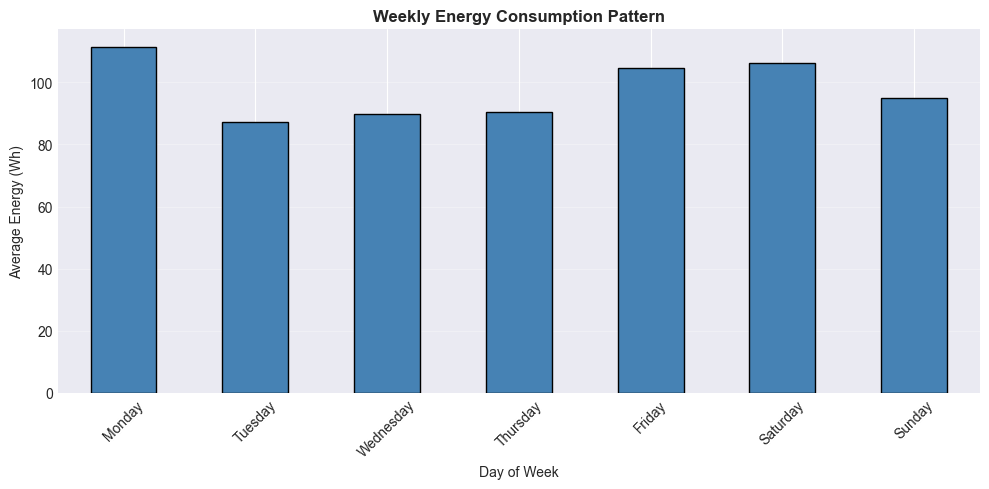

In [10]:
df['day_of_week'] = df.index.dayofweek
day_names = {0: 'Monday', 1: 'Tuesday', 2: 'Wednesday', 3: 'Thursday',
             4: 'Friday', 5: 'Saturday', 6: 'Sunday'}

weekly_stats = df.groupby('day_of_week')[target].agg(['mean', 'median', 'std'])
weekly_stats.index = [day_names[i] for i in weekly_stats.index]

print("\n📅 Weekly Statistics:")
print(weekly_stats)

fig, ax = plt.subplots(figsize=(10, 5))
weekly_stats['mean'].plot(kind='bar', ax=ax, color='steelblue', edgecolor='black')
ax.set_xlabel('Day of Week')
ax.set_ylabel('Average Energy (Wh)')
ax.set_title('Weekly Energy Consumption Pattern', fontsize=12, fontweight='bold')
ax.grid(axis='y', alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Average energy consumption is higher on weekends compared to weekdays.The difference is moderate but consistent, not extreme.

## TEMPORAL PATTERNS - MONTHLY


🗓️ Monthly Statistics:
             mean  median         std
month                                
1       97.026010    50.0  123.015094
2      100.945881    60.0  102.354279
3       96.953405    60.0   99.007133
4       98.888889    60.0  103.896607
5       94.199325    60.0   86.795158


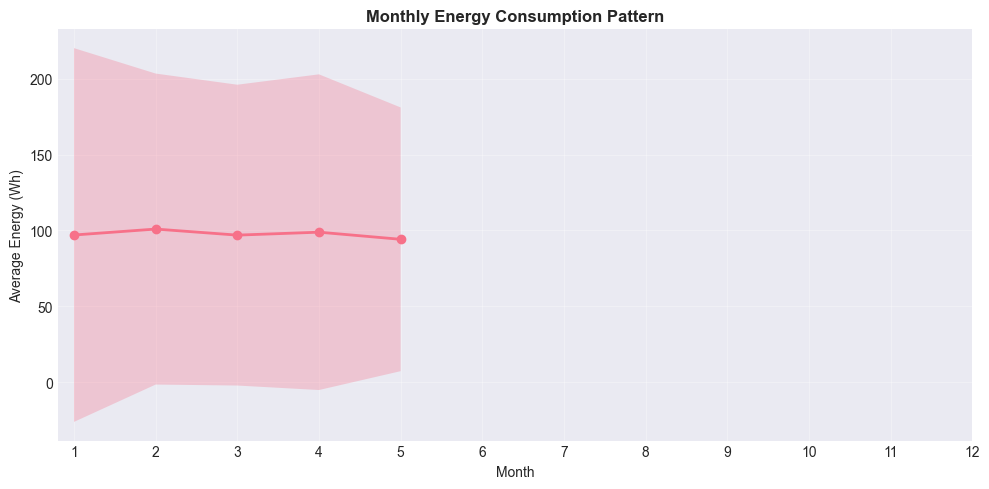

In [11]:
df['month'] = df.index.month
monthly_stats = df.groupby('month')[target].agg(['mean', 'median', 'std'])

print("\n🗓️ Monthly Statistics:")
print(monthly_stats)

fig, ax = plt.subplots(figsize=(10, 5))
monthly_stats['mean'].plot(kind='line', ax=ax, marker='o', linewidth=2, markersize=6)
ax.fill_between(monthly_stats.index, 
                monthly_stats['mean'] - monthly_stats['std'],
                monthly_stats['mean'] + monthly_stats['std'],
                alpha=0.3)
ax.set_xlabel('Month')
ax.set_ylabel('Average Energy (Wh)')
ax.set_title('Monthly Energy Consumption Pattern', fontsize=12, fontweight='bold')
ax.set_xticks(range(1, 13))
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


Energy consumption varies across months, not constant.Peak average usage occurs around Month 2.Lowest average usage is observed in Month 5.



##  TIME SERIES DECOMPOSITION

<Figure size 1400x1000 with 0 Axes>

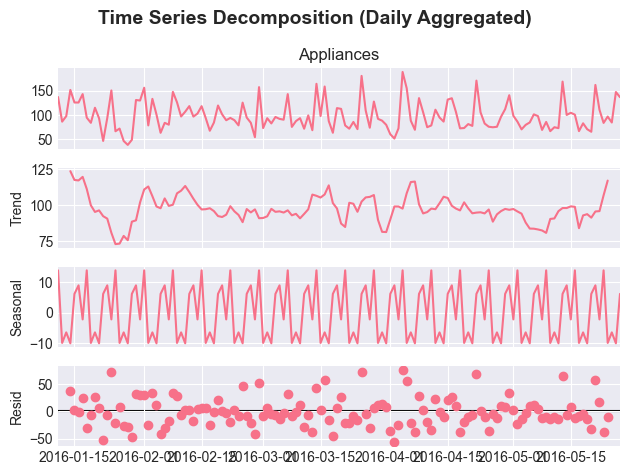

In [13]:
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose

daily_series = df[target].resample('D').mean().interpolate()

decomp = seasonal_decompose(
    daily_series,
    model='additive',
    period=7
)

plt.figure(figsize=(14, 10))
decomp.plot()
plt.suptitle(
    'Time Series Decomposition (Daily Aggregated)',
    fontsize=14,
    fontweight='bold'
)
plt.tight_layout()
plt.show()


Time series decomposition shows that the observed series is highly dynamic with frequent spikes and drops, indicating strong short-term variability driven by human behavior, making simple averaging ineffective. The trend component changes gradually over time with no strong long-term upward or downward movement, suggesting approximate trend-stationarity and a relatively stable long-term consumption level; differencing may not be strictly necessary and regression-based models are appropriate. The seasonal component exhibits clear, repeating oscillations, likely daily or weekly, confirming strong periodic behavior driven by routines and fixed appliance schedules; seasonality is therefore a key predictive signal and time-based features are essential. The residual component is centered around zero with no visible structure, indicating that most systematic patterns are captured by trend and seasonality, while remaining variation is largely random noise from unobserved or sporadic appliance usage.


## STATIONARITY TESTS

In [14]:
# ADF Test
adf_result = adfuller(df[target])
print("\n🔬 ADF (Augmented Dickey-Fuller) Test:")
print(f"   ADF Statistic: {adf_result[0]:.6f}")
print(f"   p-value: {adf_result[1]:.6f}")
print(f"   Critical Values:")
for key, value in adf_result[4].items():
    print(f"      {key}: {value:.3f}")
print(f"\n   ✅ Result: Series is STATIONARY (reject H0: unit root)" if adf_result[1] < 0.05 else "\n   ❌ Result: Series is NON-STATIONARY")

# KPSS Test
kpss_stat, kpss_p, _, _ = kpss(df[target], regression='c')
print(f"\n🔬 KPSS Test:")
print(f"   KPSS Statistic: {kpss_stat:.6f}")
print(f"   p-value: {kpss_p:.6f}")
print(f"   ✅ Result: Series is STATIONARY" if kpss_p > 0.05 else "   ❌ Result: Series is NON-STATIONARY")



🔬 ADF (Augmented Dickey-Fuller) Test:
   ADF Statistic: -21.616378
   p-value: 0.000000
   Critical Values:
      1%: -3.431
      5%: -2.862
      10%: -2.567

   ✅ Result: Series is STATIONARY (reject H0: unit root)

🔬 KPSS Test:
   KPSS Statistic: 0.036599
   p-value: 0.100000
   ✅ Result: Series is STATIONARY


Key observations: ADF statistic (-21.616) is far below critical values at 1%, 5%, and 10%, with a p-value of 0.0, providing strong evidence against the null hypothesis. The null hypothesis (H0) states that the series has a unit root and is non-stationary, while the alternative hypothesis (H1) states that the series is stationary. Since the p-value is effectively zero and the ADF statistic is highly negative, H0 is rejected, indicating that the time series is stationary.


## AUTOCORRELATION ANALYSIS

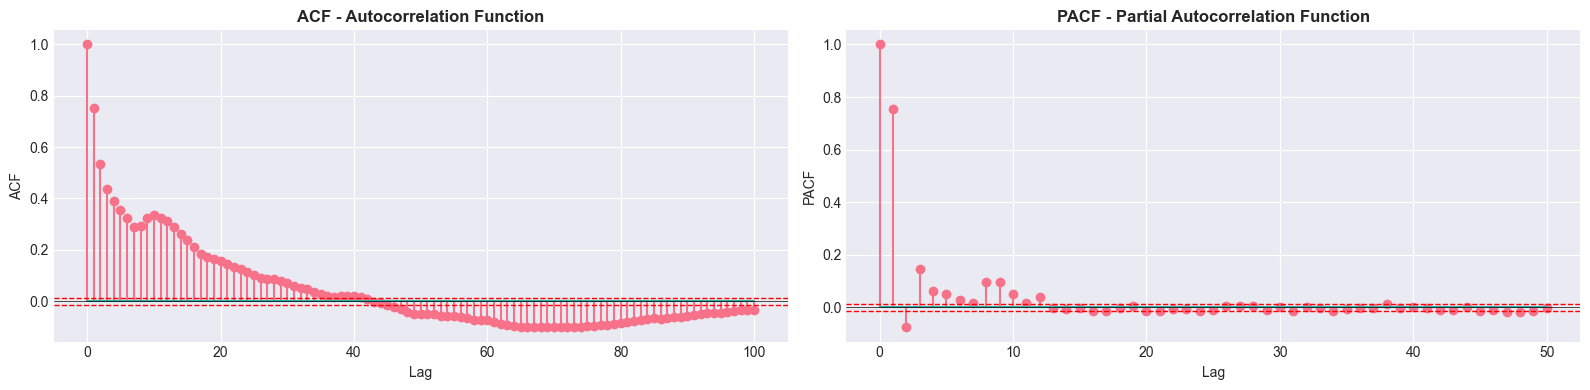


💡 Insights:
   - Strong autocorrelation at short lags indicates short-term temporal dependence
   - Rapid decay suggests that older observations have diminishing influence
   - PACF shows peak at lag 1, indicating AR(1) characteristics


In [15]:
fig, axes = plt.subplots(1, 2, figsize=(16, 4))

acf_vals = acf(df[target], nlags=100)
axes[0].stem(range(len(acf_vals)), acf_vals)
axes[0].axhline(0, color='k', linestyle='-', linewidth=0.5)
axes[0].axhline(1.96/np.sqrt(len(df)), color='r', linestyle='--', linewidth=1)
axes[0].axhline(-1.96/np.sqrt(len(df)), color='r', linestyle='--', linewidth=1)
axes[0].set_title('ACF - Autocorrelation Function', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Lag')
axes[0].set_ylabel('ACF')

pacf_vals = pacf(df[target], nlags=50)
axes[1].stem(range(len(pacf_vals)), pacf_vals)
axes[1].axhline(0, color='k', linestyle='-', linewidth=0.5)
axes[1].axhline(1.96/np.sqrt(len(df)), color='r', linestyle='--', linewidth=1)
axes[1].axhline(-1.96/np.sqrt(len(df)), color='r', linestyle='--', linewidth=1)
axes[1].set_title('PACF - Partial Autocorrelation Function', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Lag')
axes[1].set_ylabel('PACF')

plt.tight_layout()
plt.show()

print("\n💡 Insights:")
print("   - Strong autocorrelation at short lags indicates short-term temporal dependence")
print("   - Rapid decay suggests that older observations have diminishing influence")
print("   - PACF shows peak at lag 1, indicating AR(1) characteristics")


The autocorrelation of appliance energy is strong at short lags (e.g., lag 10 ≈ 0.34), indicating that recent past usage strongly influences current consumption. However, autocorrelation decays quickly and becomes slightly negative at higher lags (50+), showing that the effect of older observations diminishes. This suggests that appliance energy has short-term dependence, making models that capture recent patterns—like lag features, rolling averages, or short-window time series models—particularly useful.
The partial autocorrelation values are very low beyond lag 0, indicating that once the immediate past (lag 1–5) is accounted for, earlier lags contribute little additional predictive information. This suggests that appliance energy consumption is mostly influenced by very recent past values, and longer-term dependencies are weak. For modeling, this means short-lag features or recent rolling windows will capture most of the temporal patterns effectively.

## CORRELATION ANALYSIS


📊 Correlation with Appliances Energy:
Appliances         1.000000
hour               0.216792
lights             0.197278
T2                 0.120073
T6                 0.117638
T_out              0.099155
Windspeed          0.087122
RH_1               0.086031
T3                 0.085060
avg_indoor_temp    0.070351
T1                 0.055447
T4                 0.040281
T8                 0.039572
RH_3               0.036292
T7                 0.025801
Name: Appliances, dtype: float64
rv2                   -0.011145
month                 -0.011606
Press_mm_hg           -0.034885
RH_9                  -0.051462
RH_7                  -0.055642
avg_indoor_humidity   -0.060228
RH_2                  -0.060465
RH_6                  -0.083178
RH_8                  -0.094039
RH_out                -0.152282
Name: Appliances, dtype: float64


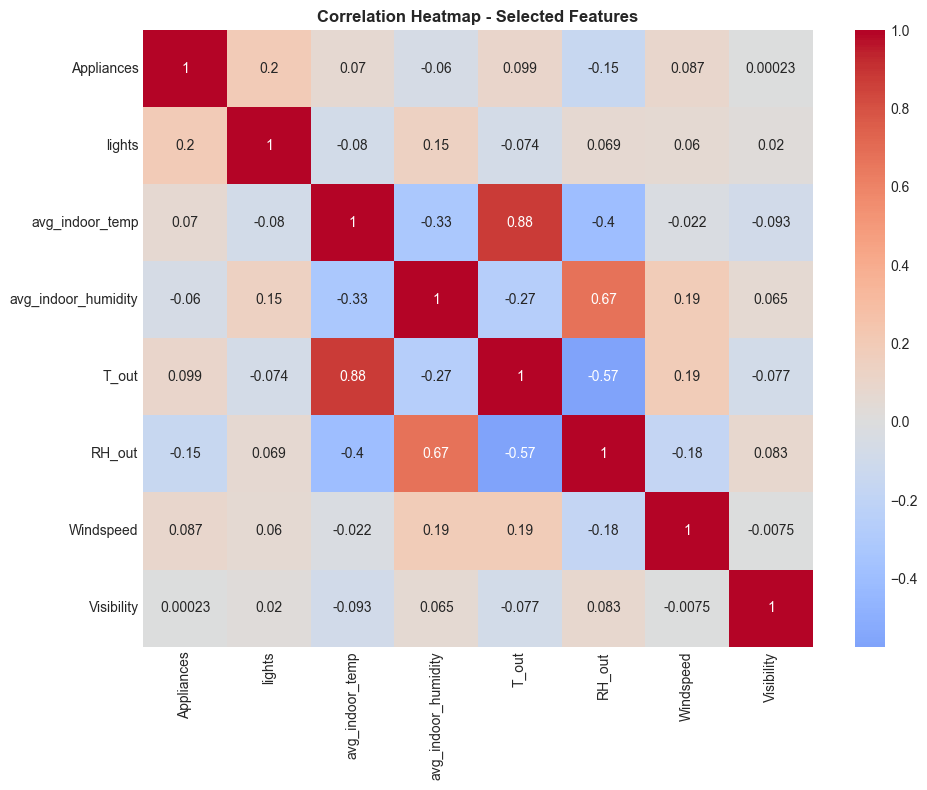

In [16]:
# Calculate aggregated indoor features
df['avg_indoor_temp'] = df[indoor_temp].mean(axis=1)
df['avg_indoor_humidity'] = df[indoor_hum].mean(axis=1)

# Correlation with target
corr_with_target = df.corr()[target].sort_values(ascending=False)
print("\n📊 Correlation with Appliances Energy:")
print(corr_with_target.head(15))
print(corr_with_target.tail(10))

# Correlation heatmap
selected_cols = [target, 'lights', 'avg_indoor_temp', 'avg_indoor_humidity', 
                 'T_out', 'RH_out', 'Windspeed', 'Visibility']
fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(df[selected_cols].corr(), annot=True, cmap='coolwarm', center=0, ax=ax)
ax.set_title('Correlation Heatmap - Selected Features', fontsize=12, fontweight='bold')
plt.tight_layout()
plt.show()


Correlation analysis shows that the strongest positive relationships with appliance energy consumption are hour (0.217), reflecting higher usage during peak times of day, and lights (0.197), which directly increases energy use. Temperatures such as T2, T6, and T_out (≈0.10–0.12) exhibit mild positive influence. Most indoor temperature and humidity variables show weak positive correlations (≈0.01–0.08), indicating limited linear impact. Outdoor humidity (RH_out, −0.152) and some indoor humidity sensors show weak negative correlations, suggesting reduced energy needs under higher humidity. Features such as visibility, weekday, month, rv1, and rv2 have near-zero correlation, implying little linear predictive power, though they may still contribute in non-linear models.


## MULTICOLLINEARITY (VIF)

In [17]:
features_raw = [
    'lights',
    'T1','RH_1','T2','RH_2','T3','RH_3','T4','RH_4','T5','RH_5',
    'T6','RH_6','T7','RH_7','T8','RH_8','T9','RH_9',
    'T_out','Press_mm_hg','RH_out','Windspeed','Visibility','Tdewpoint'
]

X_raw = df[features_raw].dropna()

vif_data = pd.DataFrame()
vif_data['Feature'] = X_raw.columns
vif_data['VIF'] = [variance_inflation_factor(X_raw.values, i) for i in range(X_raw.shape[1])]
vif_data = vif_data.sort_values('VIF', ascending=False)

print("\n🔍 Variance Inflation Factor (VIF):")
print(vif_data)

print("\n⚠️ Interpretation:")
print("   VIF < 5: Low multicollinearity (safe for linear models)")
print("   VIF 5-10: Moderate multicollinearity")
print("   VIF > 10: High multicollinearity (problematic)")



🔍 Variance Inflation Factor (VIF):
        Feature          VIF
1            T1  3606.364373
17           T9  2594.205876
3            T2  2504.688998
4          RH_2  2171.353738
20  Press_mm_hg  2086.211811
2          RH_1  1645.912655
13           T7  1614.274265
6          RH_3  1567.905984
8          RH_4  1394.025118
21       RH_out  1298.477496
5            T3  1239.182691
9            T5  1187.467542
7            T4  1027.184461
15           T8   984.861758
18         RH_9   640.395715
16         RH_8   583.050937
14         RH_7   519.429360
19        T_out   399.795514
24    Tdewpoint   132.471711
11           T6    89.062718
10         RH_5    45.206144
12         RH_6    40.389257
23   Visibility    12.033011
22    Windspeed     5.264767
0        lights     1.579656

⚠️ Interpretation:
   VIF < 5: Low multicollinearity (safe for linear models)
   VIF 5-10: Moderate multicollinearity
   VIF > 10: High multicollinearity (problematic)


VIF analysis reveals severe multicollinearity among many features. Extremely high VIFs (>1000) are observed for variables such as T1, T9, T2, RH_2, Press_mm_hg, RH_1, and T7, indicating near-linear dependence and making linear model coefficients unstable and unreliable if included together. Moderately high VIFs (≈10–100), including Tdewpoint, T6, RH_5, and RH_6, still suggest notable collinearity. In contrast, windspeed (5.26) and lights (1.58) show low VIF values, indicating minimal multicollinearity and suitability for linear modeling.


##  SPIKE & EVENT DETECTION


📊 Spike Statistics:
   Spike events (z > 2): 417 (2.11%)
   Extreme spikes (z > 3): 0 (0.00%)
   Energy from spikes: 5.57% of total


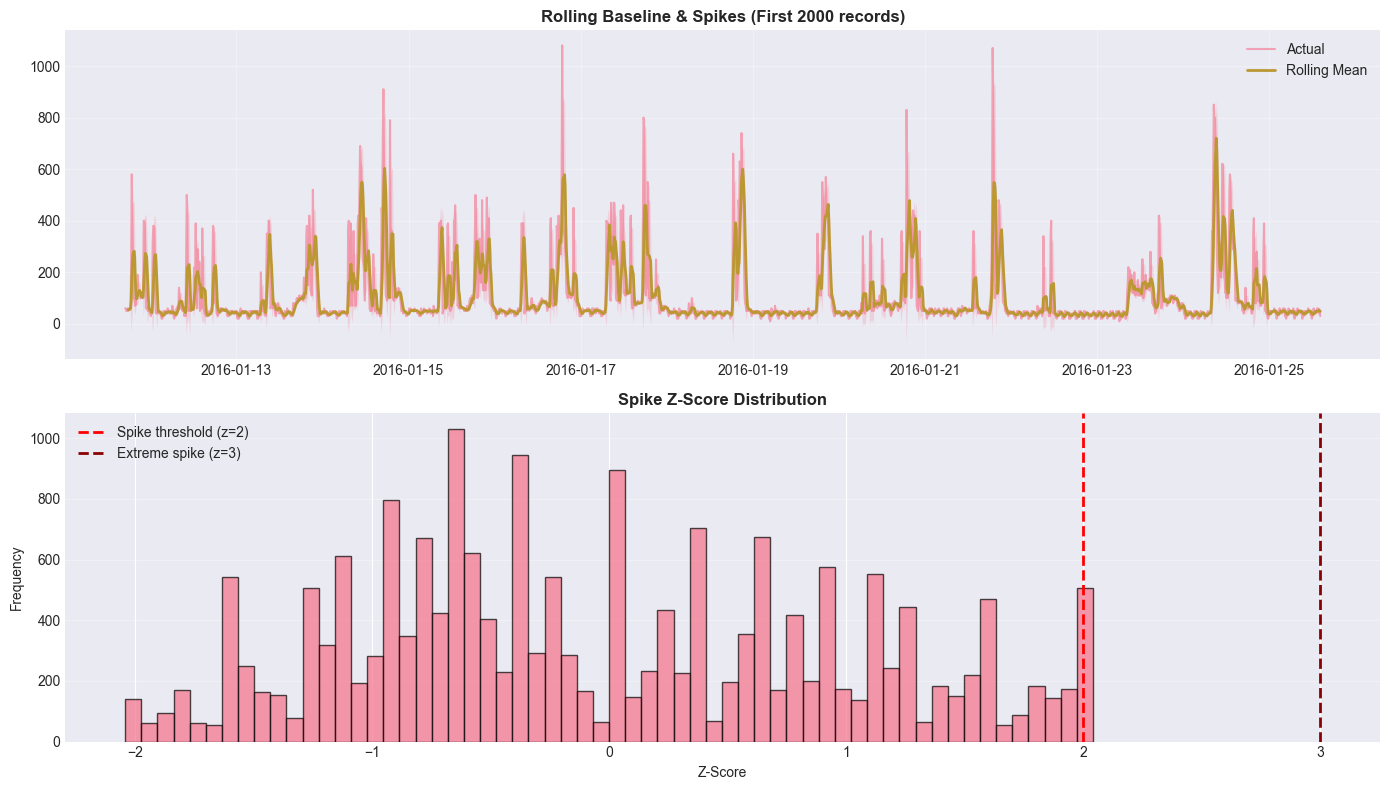

In [18]:
ROLL_WINDOW = 6  # 1 hour (6 × 10 min)
df['appl_roll_mean'] = df[target].rolling(ROLL_WINDOW).mean()
df['appl_roll_std'] = df[target].rolling(ROLL_WINDOW).std()
df['spike_strength'] = df[target] - df['appl_roll_mean']
df['spike_z'] = df['spike_strength'] / df['appl_roll_std']
df['is_spike'] = (df['spike_z'] > 2).astype(int)
df['is_extreme_spike'] = (df['spike_z'] > 3).astype(int)

print("\n📊 Spike Statistics:")
print(f"   Spike events (z > 2): {df['is_spike'].sum()} ({df['is_spike'].mean()*100:.2f}%)")
print(f"   Extreme spikes (z > 3): {df['is_extreme_spike'].sum()} ({df['is_extreme_spike'].mean()*100:.2f}%)")

total_energy = df[target].sum()
spike_energy = df[df['is_spike'] == 1][target].sum()
print(f"   Energy from spikes: {spike_energy/total_energy*100:.2f}% of total")

# Visualization
fig, axes = plt.subplots(2, 1, figsize=(14, 8))

# Rolling baseline
axes[0].plot(df.index[:2000], df[target].iloc[:2000], alpha=0.6, label='Actual')
axes[0].plot(df.index[:2000], df['appl_roll_mean'].iloc[:2000], linewidth=2, label='Rolling Mean')
axes[0].fill_between(df.index[:2000],
                     df['appl_roll_mean'].iloc[:2000] - df['appl_roll_std'].iloc[:2000],
                     df['appl_roll_mean'].iloc[:2000] + df['appl_roll_std'].iloc[:2000],
                     alpha=0.2)
axes[0].set_title('Rolling Baseline & Spikes (First 2000 records)', fontsize=12, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Z-score distribution
axes[1].hist(df['spike_z'].dropna(), bins=60, edgecolor='black', alpha=0.7)
axes[1].axvline(2, color='red', linestyle='--', linewidth=2, label='Spike threshold (z=2)')
axes[1].axvline(3, color='darkred', linestyle='--', linewidth=2, label='Extreme spike (z=3)')
axes[1].set_xlabel('Z-Score')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Spike Z-Score Distribution', fontsize=12, fontweight='bold')
axes[1].legend()
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()


## FEATURE DISTRIBUTIONS & SKEWNESS

In [19]:
skewness = df.skew(numeric_only=True).sort_values(ascending=False)
print("\n📈 Skewness Analysis (Top 10):")
print(skewness.head(10))

variance = df.var(numeric_only=True).sort_values(ascending=False)
print("\n📊 Variance Analysis (Top 10):")
print(variance.head(10))


📈 Skewness Analysis (Top 10):
is_spike           6.659915
Appliances         3.386367
appl_roll_mean     2.437364
appl_roll_std      2.278385
lights             2.195155
spike_strength     2.146157
RH_5               1.866820
T2                 0.889658
Windspeed          0.859982
avg_indoor_temp    0.625537
dtype: float64

📊 Variance Analysis (Top 10):
Appliances        10511.353180
appl_roll_mean     6627.105173
spike_strength     4971.790613
appl_roll_std      3265.228261
RH_6                970.310406
RH_out              222.042410
rv2                 210.152393
rv1                 210.152393
Visibility          139.115391
RH_5                 81.397103
dtype: float64


The target variable Appliances is highly positively skewed (3.39), indicating frequent low-to-moderate energy values with occasional large spikes. A log transformation or similar normalization can help stabilize variance and improve model performance.Features like lights (2.20), RH_5 (1.87), and Appliances_log (1.19) are also positively skewed, suggesting uneven distributions.Most other features have low to moderate skewness (between -0.5 and 0.5), meaning they are fairly symmetric.

RH_out shows moderate negative skew (-0.92), indicating occasional low values.The target Appliances shows very high variance (~10511), reflecting large fluctuations in energy usage and the presence of extreme spikes.Most temperature (T*) and humidity (RH*) features have moderate variance, while categorical or binary features (is_weekend, month, weekday, day_of_week) have low variance.Features with low variance (e.g., is_weekend) may contribute less predictive power unless combined with other features

## LIGHTS FEATURE ANALYSIS AND ENVIRONMENTAL FEATURES


💡 Lighting Energy Statistics:
   Mean: 3.80 Wh
   Median: 0.00 Wh
   Zero values: 15252 (77.28%)
   Max: 70.00 Wh


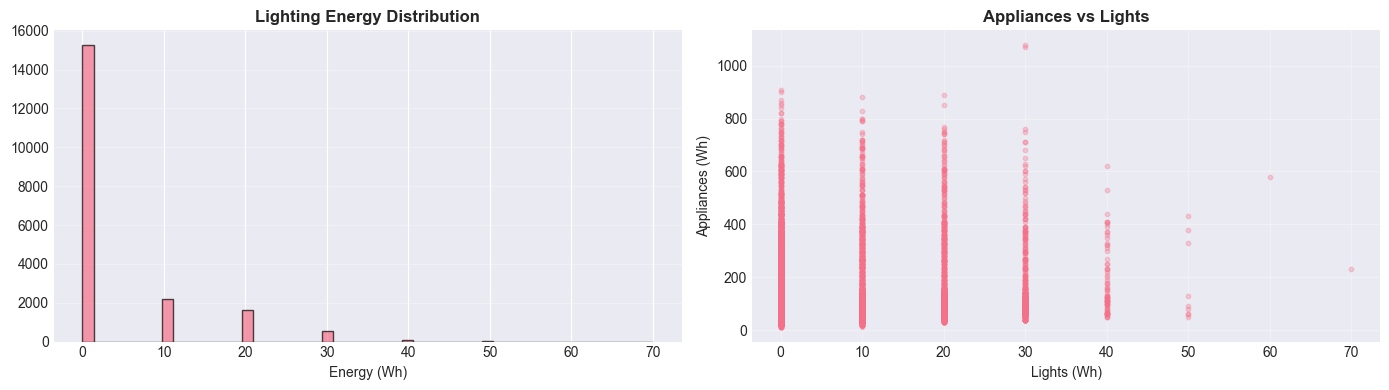


SECTION 18: ENVIRONMENTAL FEATURES

🌡️ Aggregated Temperature Statistics:
   Indoor Avg Mean: 17.82°C
   Indoor Avg Std: 2.24°C
   Outdoor Mean: 7.41°C
   Outdoor Range: -5.00°C to 26.10°C

💧 Aggregated Humidity Statistics:
   Indoor Avg Mean: 42.71%
   Outdoor Mean: 79.75%


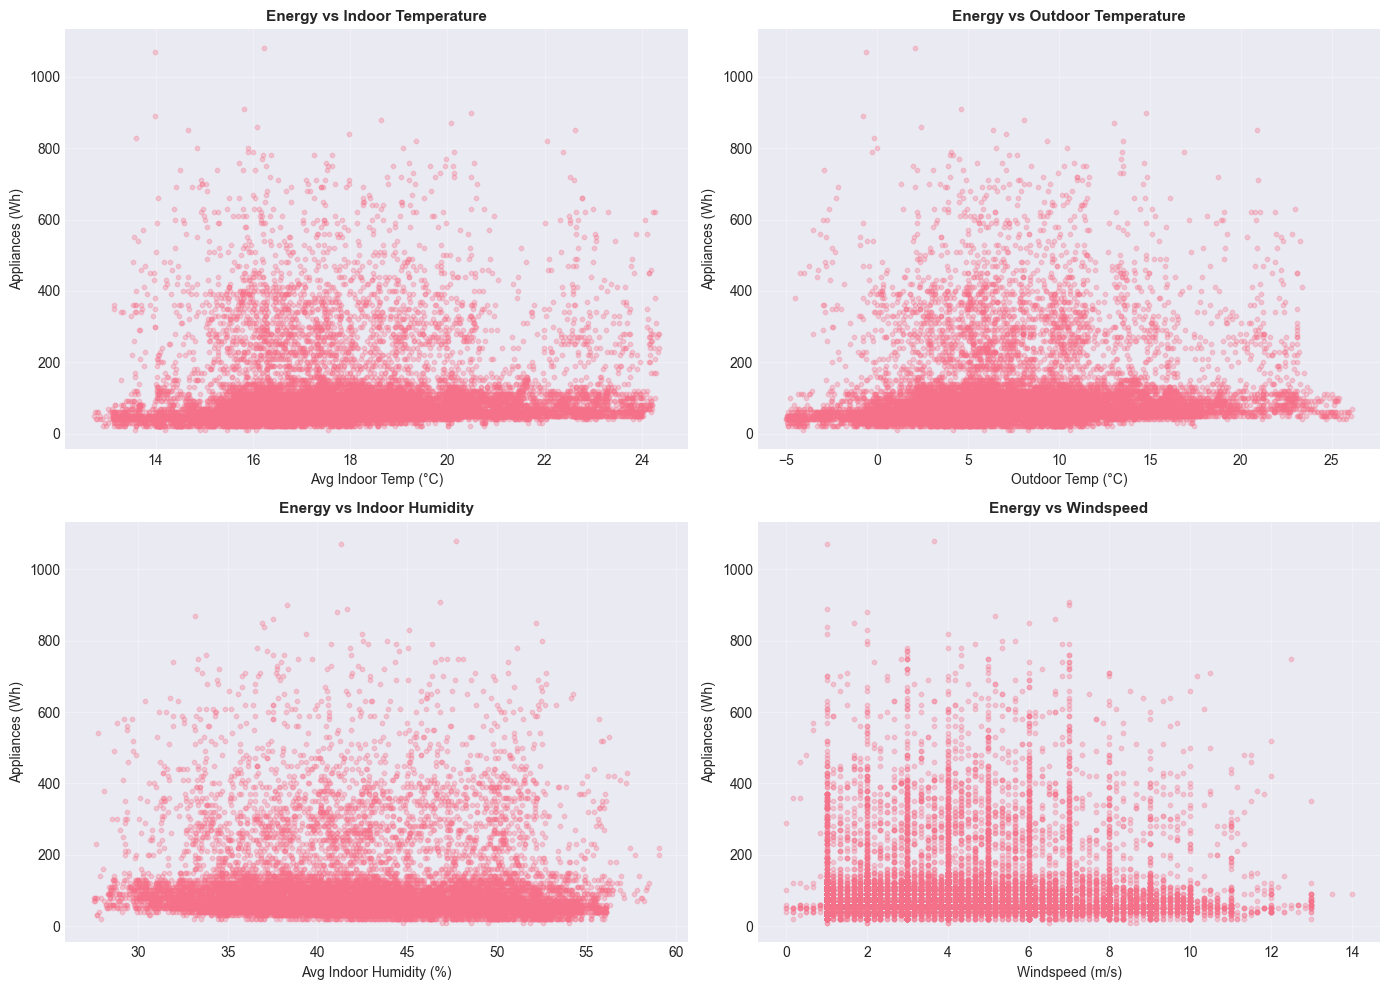

In [20]:
print("\n💡 Lighting Energy Statistics:")
print(f"   Mean: {df['lights'].mean():.2f} Wh")
print(f"   Median: {df['lights'].median():.2f} Wh")
print(f"   Zero values: {(df['lights'] == 0).sum()} ({(df['lights'] == 0).mean()*100:.2f}%)")
print(f"   Max: {df['lights'].max():.2f} Wh")

fig, axes = plt.subplots(1, 2, figsize=(14, 4))

axes[0].hist(df['lights'], bins=50, edgecolor='black', alpha=0.7)
axes[0].set_title('Lighting Energy Distribution', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Energy (Wh)')
axes[0].grid(axis='y', alpha=0.3)

axes[1].scatter(df['lights'], df[target], alpha=0.3, s=10)
axes[1].set_xlabel('Lights (Wh)')
axes[1].set_ylabel('Appliances (Wh)')
axes[1].set_title('Appliances vs Lights', fontsize=12, fontweight='bold')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n" + "=" * 80)
print("SECTION 18: ENVIRONMENTAL FEATURES")
print("=" * 80)

print("\n🌡️ Aggregated Temperature Statistics:")
print(f"   Indoor Avg Mean: {df['avg_indoor_temp'].mean():.2f}°C")
print(f"   Indoor Avg Std: {df['avg_indoor_temp'].std():.2f}°C")
print(f"   Outdoor Mean: {df['T_out'].mean():.2f}°C")
print(f"   Outdoor Range: {df['T_out'].min():.2f}°C to {df['T_out'].max():.2f}°C")

print("\n💧 Aggregated Humidity Statistics:")
print(f"   Indoor Avg Mean: {df['avg_indoor_humidity'].mean():.2f}%")
print(f"   Outdoor Mean: {df['RH_out'].mean():.2f}%")

# Scatter plots
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

axes[0, 0].scatter(df['avg_indoor_temp'], df[target], alpha=0.3, s=10)
axes[0, 0].set_xlabel('Avg Indoor Temp (°C)')
axes[0, 0].set_ylabel('Appliances (Wh)')
axes[0, 0].set_title('Energy vs Indoor Temperature', fontsize=11, fontweight='bold')
axes[0, 0].grid(True, alpha=0.3)

axes[0, 1].scatter(df['T_out'], df[target], alpha=0.3, s=10)
axes[0, 1].set_xlabel('Outdoor Temp (°C)')
axes[0, 1].set_ylabel('Appliances (Wh)')
axes[0, 1].set_title('Energy vs Outdoor Temperature', fontsize=11, fontweight='bold')
axes[0, 1].grid(True, alpha=0.3)

axes[1, 0].scatter(df['avg_indoor_humidity'], df[target], alpha=0.3, s=10)
axes[1, 0].set_xlabel('Avg Indoor Humidity (%)')
axes[1, 0].set_ylabel('Appliances (Wh)')
axes[1, 0].set_title('Energy vs Indoor Humidity', fontsize=11, fontweight='bold')
axes[1, 0].grid(True, alpha=0.3)

axes[1, 1].scatter(df['Windspeed'], df[target], alpha=0.3, s=10)
axes[1, 1].set_xlabel('Windspeed (m/s)')
axes[1, 1].set_ylabel('Appliances (Wh)')
axes[1, 1].set_title('Energy vs Windspeed', fontsize=11, fontweight='bold')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


## TEMPORAL PATTERNS - DAY WISE

In [22]:
# Create day-of-week column (Monday=0)
df['day_of_week'] = df.index.dayofweek

# Mapping for labels
day_names = {
    0: 'Monday', 1: 'Tuesday', 2: 'Wednesday',
    3: 'Thursday', 4: 'Friday', 5: 'Saturday', 6: 'Sunday'
}

# Aggregate energy consumption by day
app_week_day = (
    df.groupby('day_of_week')['Appliances']
      .mean()
      .reset_index()
      .sort_values('day_of_week')
)


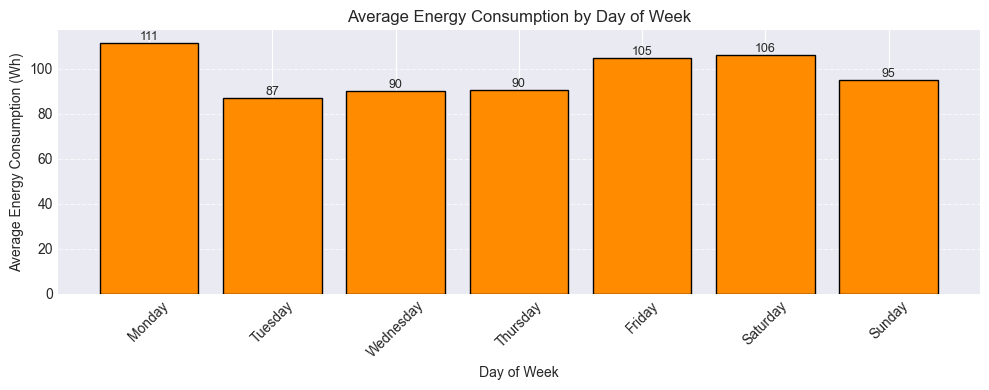

In [26]:
def format_value(value):
    return f"{value:.0f}"   # no decimals

plt.figure(figsize=(10, 4))

bars = plt.bar(
    app_week_day['day_of_week'],
    app_week_day['Appliances'],
    color='darkorange',
    edgecolor='black'
)

# Annotate bars
for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        height,
        format_value(height),
        ha='center',
        va='bottom',
        fontsize=9
    )

plt.xlabel('Day of Week')
plt.ylabel('Average Energy Consumption (Wh)')
plt.title('Average Energy Consumption by Day of Week')
plt.xticks(
    app_week_day['day_of_week'],
    [day_names[d] for d in app_week_day['day_of_week']],
    rotation=45
)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


Average energy consumption by day of week shows highest usage on Monday, elevated usage on Friday and Saturday, lower and stable consumption Tuesday–Thursday, and a slight dip on Sunday. Monday spikes likely reflect post-weekend routines and increased appliance activity after inactivity. Higher consumption on Friday–Saturday corresponds to more time spent at home and leisure or household activities, while mid-week stability indicates predictable routines.


## OTHERS

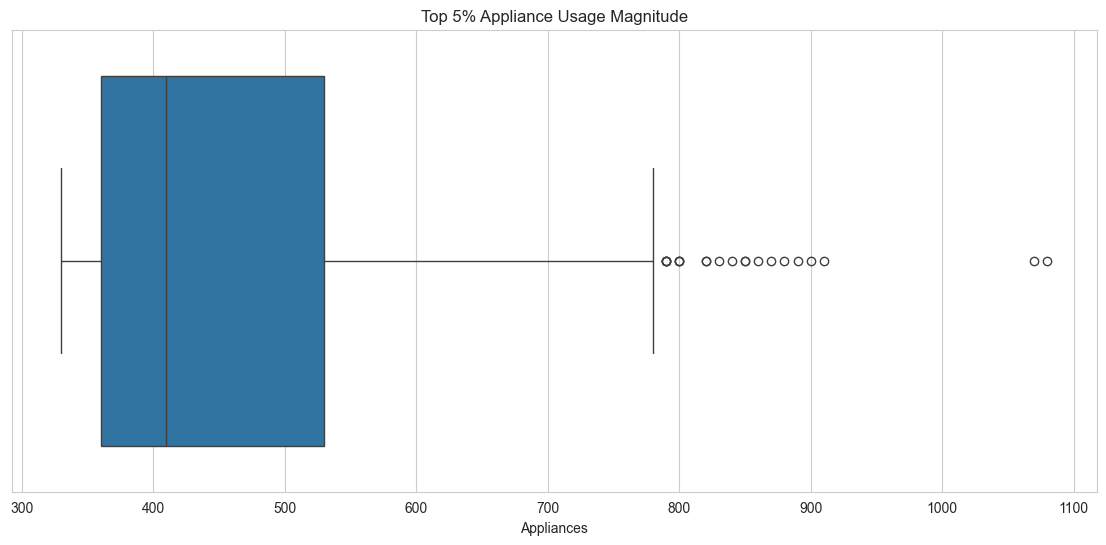

In [41]:
high_usage = df[df['Appliances'] >= df['Appliances'].quantile(0.95)]

plt.figure()
sns.boxplot(x=high_usage['Appliances'])
plt.title("Top 5% Appliance Usage Magnitude")
plt.show()
